In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
data_train = pd.read_csv('./input/train.csv')
X_test = pd.read_csv('./input/test.csv')
data = data_train.append(X_test, ignore_index=True, sort=False)
data = pd.get_dummies(data, dummy_na=True, drop_first=True)
data.drop('Id', axis=1, inplace=True)
data.isnull().values.any()

True

In [3]:
data.fillna(data.median(), inplace=True)
columns = data.columns
sale_price = data['SalePrice']
data.isnull().values.any()

False

In [4]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['SalePrice'] = sale_price
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
train = data.iloc[:1460]
test = data.iloc[1460:]
test.drop('SalePrice', axis=1, inplace=True)

C:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.2, random_state=42)

In [7]:
X_train.shape

(1168, 288)

In [8]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(288, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)

        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):

        #x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        return x

In [9]:
train_batch = np.array_split(X_train, 50)
label_batch = np.array_split(y_train, 50)

In [10]:
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)

X_val = torch.from_numpy(X_val.values).float()
y_val = torch.from_numpy(y_val.values).float().view(-1, 1)

In [11]:
model = Regressor()
ps = model(train_batch[0])
ps.shape

torch.Size([24, 1])

In [12]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 300

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.3f}.. ".format(test_loss))

Epoch: 1/300..  Training Loss: 10.595..  Test Loss: 8.432.. 
Epoch: 2/300..  Training Loss: 7.461..  Test Loss: 6.610.. 
Epoch: 3/300..  Training Loss: 6.083..  Test Loss: 5.550.. 
Epoch: 4/300..  Training Loss: 5.186..  Test Loss: 4.781.. 
Epoch: 5/300..  Training Loss: 4.495..  Test Loss: 4.164.. 
Epoch: 6/300..  Training Loss: 3.933..  Test Loss: 3.653.. 
Epoch: 7/300..  Training Loss: 3.461..  Test Loss: 3.222.. 
Epoch: 8/300..  Training Loss: 3.061..  Test Loss: 2.852.. 
Epoch: 9/300..  Training Loss: 2.715..  Test Loss: 2.529.. 
Epoch: 10/300..  Training Loss: 2.408..  Test Loss: 2.241.. 
Epoch: 11/300..  Training Loss: 2.133..  Test Loss: 1.980.. 
Epoch: 12/300..  Training Loss: 1.883..  Test Loss: 1.741.. 
Epoch: 13/300..  Training Loss: 1.652..  Test Loss: 1.520.. 
Epoch: 14/300..  Training Loss: 1.435..  Test Loss: 1.313.. 
Epoch: 15/300..  Training Loss: 1.232..  Test Loss: 1.119.. 
Epoch: 16/300..  Training Loss: 1.043..  Test Loss: 0.941.. 
Epoch: 17/300..  Training Loss: 

Epoch: 136/300..  Training Loss: 0.119..  Test Loss: 0.168.. 
Epoch: 137/300..  Training Loss: 0.118..  Test Loss: 0.168.. 
Epoch: 138/300..  Training Loss: 0.118..  Test Loss: 0.167.. 
Epoch: 139/300..  Training Loss: 0.117..  Test Loss: 0.167.. 
Epoch: 140/300..  Training Loss: 0.117..  Test Loss: 0.166.. 
Epoch: 141/300..  Training Loss: 0.116..  Test Loss: 0.166.. 
Epoch: 142/300..  Training Loss: 0.116..  Test Loss: 0.166.. 
Epoch: 143/300..  Training Loss: 0.115..  Test Loss: 0.165.. 
Epoch: 144/300..  Training Loss: 0.115..  Test Loss: 0.165.. 
Epoch: 145/300..  Training Loss: 0.114..  Test Loss: 0.165.. 
Epoch: 146/300..  Training Loss: 0.114..  Test Loss: 0.164.. 
Epoch: 147/300..  Training Loss: 0.113..  Test Loss: 0.164.. 
Epoch: 148/300..  Training Loss: 0.113..  Test Loss: 0.163.. 
Epoch: 149/300..  Training Loss: 0.112..  Test Loss: 0.163.. 
Epoch: 150/300..  Training Loss: 0.112..  Test Loss: 0.163.. 
Epoch: 151/300..  Training Loss: 0.111..  Test Loss: 0.162.. 
Epoch: 1

Epoch: 269/300..  Training Loss: 0.080..  Test Loss: 0.147.. 
Epoch: 270/300..  Training Loss: 0.080..  Test Loss: 0.147.. 
Epoch: 271/300..  Training Loss: 0.080..  Test Loss: 0.147.. 
Epoch: 272/300..  Training Loss: 0.079..  Test Loss: 0.147.. 
Epoch: 273/300..  Training Loss: 0.079..  Test Loss: 0.147.. 
Epoch: 274/300..  Training Loss: 0.079..  Test Loss: 0.147.. 
Epoch: 275/300..  Training Loss: 0.079..  Test Loss: 0.147.. 
Epoch: 276/300..  Training Loss: 0.079..  Test Loss: 0.147.. 
Epoch: 277/300..  Training Loss: 0.078..  Test Loss: 0.147.. 
Epoch: 278/300..  Training Loss: 0.078..  Test Loss: 0.147.. 
Epoch: 279/300..  Training Loss: 0.078..  Test Loss: 0.147.. 
Epoch: 280/300..  Training Loss: 0.078..  Test Loss: 0.147.. 
Epoch: 281/300..  Training Loss: 0.078..  Test Loss: 0.147.. 
Epoch: 282/300..  Training Loss: 0.078..  Test Loss: 0.147.. 
Epoch: 283/300..  Training Loss: 0.077..  Test Loss: 0.147.. 
Epoch: 284/300..  Training Loss: 0.077..  Test Loss: 0.147.. 
Epoch: 2

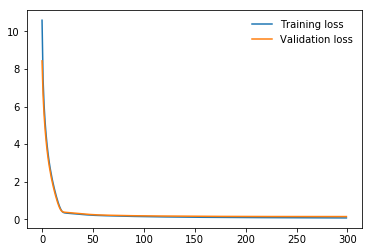

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [14]:
test = torch.from_numpy(test.values).float()

with torch.no_grad():
    model.eval()
    output = model.forward(test)

output.shape

torch.Size([1459, 1])

In [15]:
submission = pd.read_csv('./input/sample_submission.csv')
submission['SalePrice'] = output.numpy()
submission.to_csv('submission.csv', index=False)

In [16]:
submission

,Id,SalePrice
0,1461,128364.875000
1,1462,157989.125000
2,1463,182233.000000
3,1464,186996.046875
4,1465,200391.906250
5,1466,171916.250000
6,1467,174920.703125
7,1468,154836.984375
8,1469,180462.125000
9,1470,130878.476562
